In [ ]:
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imag
from skimage import color
import torch
from skimage import io
from scipy.ndimage import gaussian_filter
from scipy import ndimage, misc
from google.colab.patches import cv2_imshow
import time

In [ ]:
!wget https://epic.gs.washington.edu/mov/20081016_alr-1_10A2_3_L1.mov

--2021-04-03 11:13:18--  https://epic.gs.washington.edu/mov/20081016_alr-1_10A2_3_L1.mov
Resolving epic.gs.washington.edu (epic.gs.washington.edu)... 128.208.9.147
Connecting to epic.gs.washington.edu (epic.gs.washington.edu)|128.208.9.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010006 (986K) [video/quicktime]
Saving to: ‘20081016_alr-1_10A2_3_L1.mov’

20081016_alr-1_10A2 100%[===================>] 986.33K  --.-KB/s    in 0.07s   

2021-04-03 11:13:18 (13.4 MB/s) - ‘20081016_alr-1_10A2_3_L1.mov’ saved [1010006/1010006]



In [ ]:
!mkdir output
%cd output

vidcap = cv2.VideoCapture('/content/20081016_alr-1_10A2_3_L1.mov')

success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)         
  success,image = vidcap.read()
  count += 1
print("Frames saved")

/content/output
Frames saved


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


(512, 712, 3)


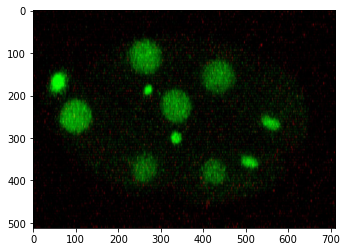

In [ ]:
img = plt.imread("/content/output/frame2.jpg")
print(img.shape)
plt.imshow(img)

In [ ]:
def filter_images(img,sig,md_size,device):
  img = gaussian_filter(img, sigma=sig) 
  img = cv2.medianBlur(img, 9)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  image = torch.tensor(np.array(img), device=device)
  return image

In [ ]:
def generate_ls(dmax,dell,device):
  lmin = 0.35*dmax
  lmax = 0.85*dmax
  smax=((lmax-lmin)/dell)+1
  ls = torch.zeros((int(smax),1),device=device)
  for i in range (0, int(smax)):
    ls[i] = lmin+(i-0)*dell

  return ls,smax

In [ ]:
def lei(image,ls,smax,device):
  image_temp = torch.zeros((image.shape[0],image.shape[1]),device=device)
  fill_ls = torch.zeros((image.shape[0],image.shape[1],int(smax)),device=device)
  image_temp = image
  image_temp = image_temp.unsqueeze(0)
  image_temp = image_temp.unsqueeze(0)

  for k in range(0,int(smax)):
    rad = int(ls[k][0])
    print(rad)
    kernel = torch.ones((rad+1,rad+1),device=device)
    kernel[int(rad/2)+1,int(rad/2)+1] = 0
    kernel = kernel.unsqueeze(0)
    kernel = kernel.unsqueeze(0)

    padding = torch.nn.ConstantPad2d((int(rad/2), int(rad/2), int(rad/2), int(rad/2)), 0)

    image_pad = padding(image_temp)

    conv_filter = torch.nn.Conv2d(in_channels = 1, out_channels = 1, 
                      kernel_size=(rad+1,rad+1), stride=1, groups=1, bias=False)

    conv_filter.weight.data = kernel
    conv_filter.weight.requires_grad = False 
    image_pad = image_pad.float()
    fill_ls[:,:,k] = conv_filter(image_pad)

  lopt = torch.zeros((fill_ls.shape[0],fill_ls.shape[1]),device=device)
  lopt =  torch.amax(fill_ls, axis=2)
  return lopt

In [ ]:
def generate_rmat(lopt,candidate,device):
  r_mat = torch.zeros((lopt.shape[0],lopt.shape[1]),device=device)
  padding = torch.nn.ConstantPad2d((int(candidate), int(candidate), int(candidate), int(candidate)), 0)
  lopt_p = padding(lopt)
  lopt_p = lopt_p.unsqueeze(0)
  lopt_p = lopt_p.unsqueeze(0)
  unfold = torch.nn.Unfold(((2*candidate)+1,(2*candidate)+1), dilation=1, padding=0, stride=1)
  patch = unfold(lopt_p)
  patch=patch.squeeze(0)
  patch = patch.reshape(9,9,364544)
  patch = torch.where(patch[:,:,:]<patch[4,4,:],1,0)
  patch = patch.reshape(81,364544)
  patch = patch.sum(dim=0)
  patch = patch.reshape(512,712)
  patch = torch.div(patch,(candidate*2)**2 )
  r_mat=patch
  return r_mat

In [ ]:
def stage1(thresh, rmat, device):
  i_st1 = torch.zeros(rmat.shape,device=device)
  i_st1 = torch.where(rmat>thresh, 1, 0)

  return i_st1 

In [ ]:
def shape_score(dmax,lopt,i_st1,device):

  profile_len = int(0.7*dmax)
  s_shape = torch.zeros((lopt.shape[0],lopt.shape[1]),device=device)

  for i in range(0,lopt.shape[0]-1):
    for j in range(0, lopt.shape[1]-1):
      if i_st1[i,j] == 1:
        if lopt[i,j] > lopt[i,j+1]:
          temp = lopt[i,j:j+int(profile_len/2)]
          sx = torch.sum(temp)/(2*profile_len)
        elif lopt[i,j] < lopt[i,j+1]:
          temp = lopt[i,j-int(profile_len/2):j]
          sx = torch.sum(temp)/(profile_len)
        else:
          sx = 0;
        if lopt[i,j] > lopt[i+1,j]:
          temp = lopt[i:i+int(profile_len/2),j]
          sy = torch.sum(temp)/(2*profile_len)
        elif lopt[i,j] < lopt[i+1,j]:
          temp = lopt[i-int(profile_len/2):i,j]
          sy = torch.sum(temp)/(profile_len)
        else:
          sy = 0;
        s_shape[i,j] = (sx+sy)/2

  max_shape = torch.amax(s_shape)
  return s_shape,max_shape

In [ ]:
def stage2(thresh,s_shape,device):
  i_st2 = torch.zeros((s_shape.shape[0],s_shape.shape[1]))
  i_st2 = torch.where(s_shape>thresh,1,0)

  return i_st2

cuda:0


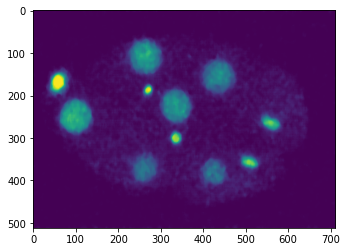

In [ ]:
image = filter_images(img,0.35,9,device)

print(image.device)
plt.imshow(image.cpu())

In [ ]:
ls,smax = generate_ls(48,4,device)
print(ls.device)

cuda:0


16
20
24
28
32
36
40
cuda:0


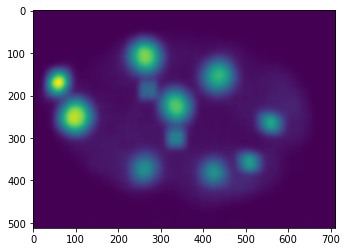

In [ ]:
lopt = lei(image,ls,smax,device)
print(lopt.device)
plt.imshow(lopt.cpu())


cuda:0


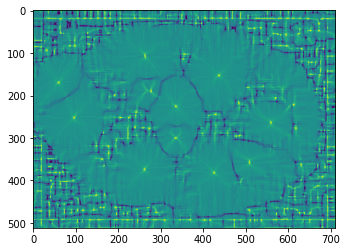

In [ ]:
r_mat = generate_rmat(lopt,4,device)
print(r_mat.device)
plt.imshow(r_mat.cpu()*100)

cuda:0


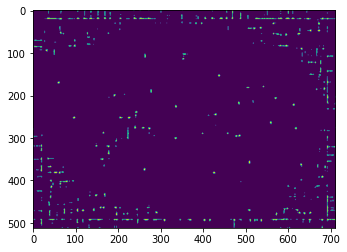

In [ ]:
i_st1 = stage1(0.99999, patch, device)
print(i_st1.device)
plt.imshow(i_st1.cpu()*255)

In [ ]:
print(lopt.shape)

torch.Size([512, 712])


In [ ]:
s_shape,max_shape = shape_score(48,lopt,i_st1,device)
print(s_shape.device)
print(max_shape)

cuda:0
tensor(67995.9844, device='cuda:0')


cuda:0


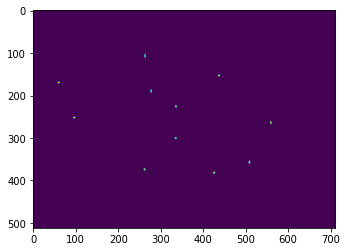

In [ ]:
i_st2 = stage2(10000,s_shape,device)
print(i_st2.device)
plt.imshow(i_st2.cpu()*255)

In [ ]:
centroids = []
for i in range(0,image.shape[0]):
  for j in range(0, image.shape[1]):
    if i_st2[i,j] == 1:
      centroids.append([i,j])


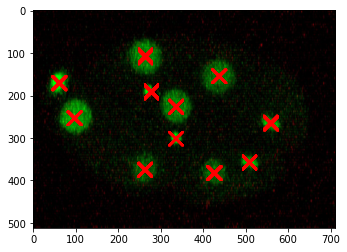

In [ ]:
centre = np.array(centroids)

plt.imshow(img)
plt.scatter(centre[:, 1], centre[:, 0], marker="x", color="red", s=200)
plt.show()

In [ ]:
#time taken (can be further improved by optimising the shape score function )
startTime = time.time()
image = filter_images(img,0.35,9,device)
ls,smax = generate_ls(48,4,device)
lopt = lei(image,ls,smax,device)
r_mat = generate_rmat(lopt,4,device)
i_st1 = stage1(0.99999, patch, device)
i_st2 = stage2(10000,s_shape,device)
endTime = time.time()
print("execution time :" +str(endTime-startTime))

16
20
24
28
32
36
40
execution time :0.14409756660461426
